<a href="https://colab.research.google.com/github/acarbn/portfolio/blob/main/EnrichmentScoreVsGNM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install biopython

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Do you want to upload the file from your computer (c) or Google Drive (g)? [c/g]: g
Enrichment scores loaded.
1EU8  structure is found.
MSF data for mode 1 is calculated.
MSF data for mode 2 is calculated.
MSF data for mode 3 is calculated.
MSF data for mode 4 is calculated.
MSF data for mode 5 is calculated.
MSF data for mode 6 is calculated.
MSF data for mode 7 is calculated.
MSF data for mode 8 is calculated.
MSF data for mode 9 is calculated.
MSF data for mode 10 is calculated.


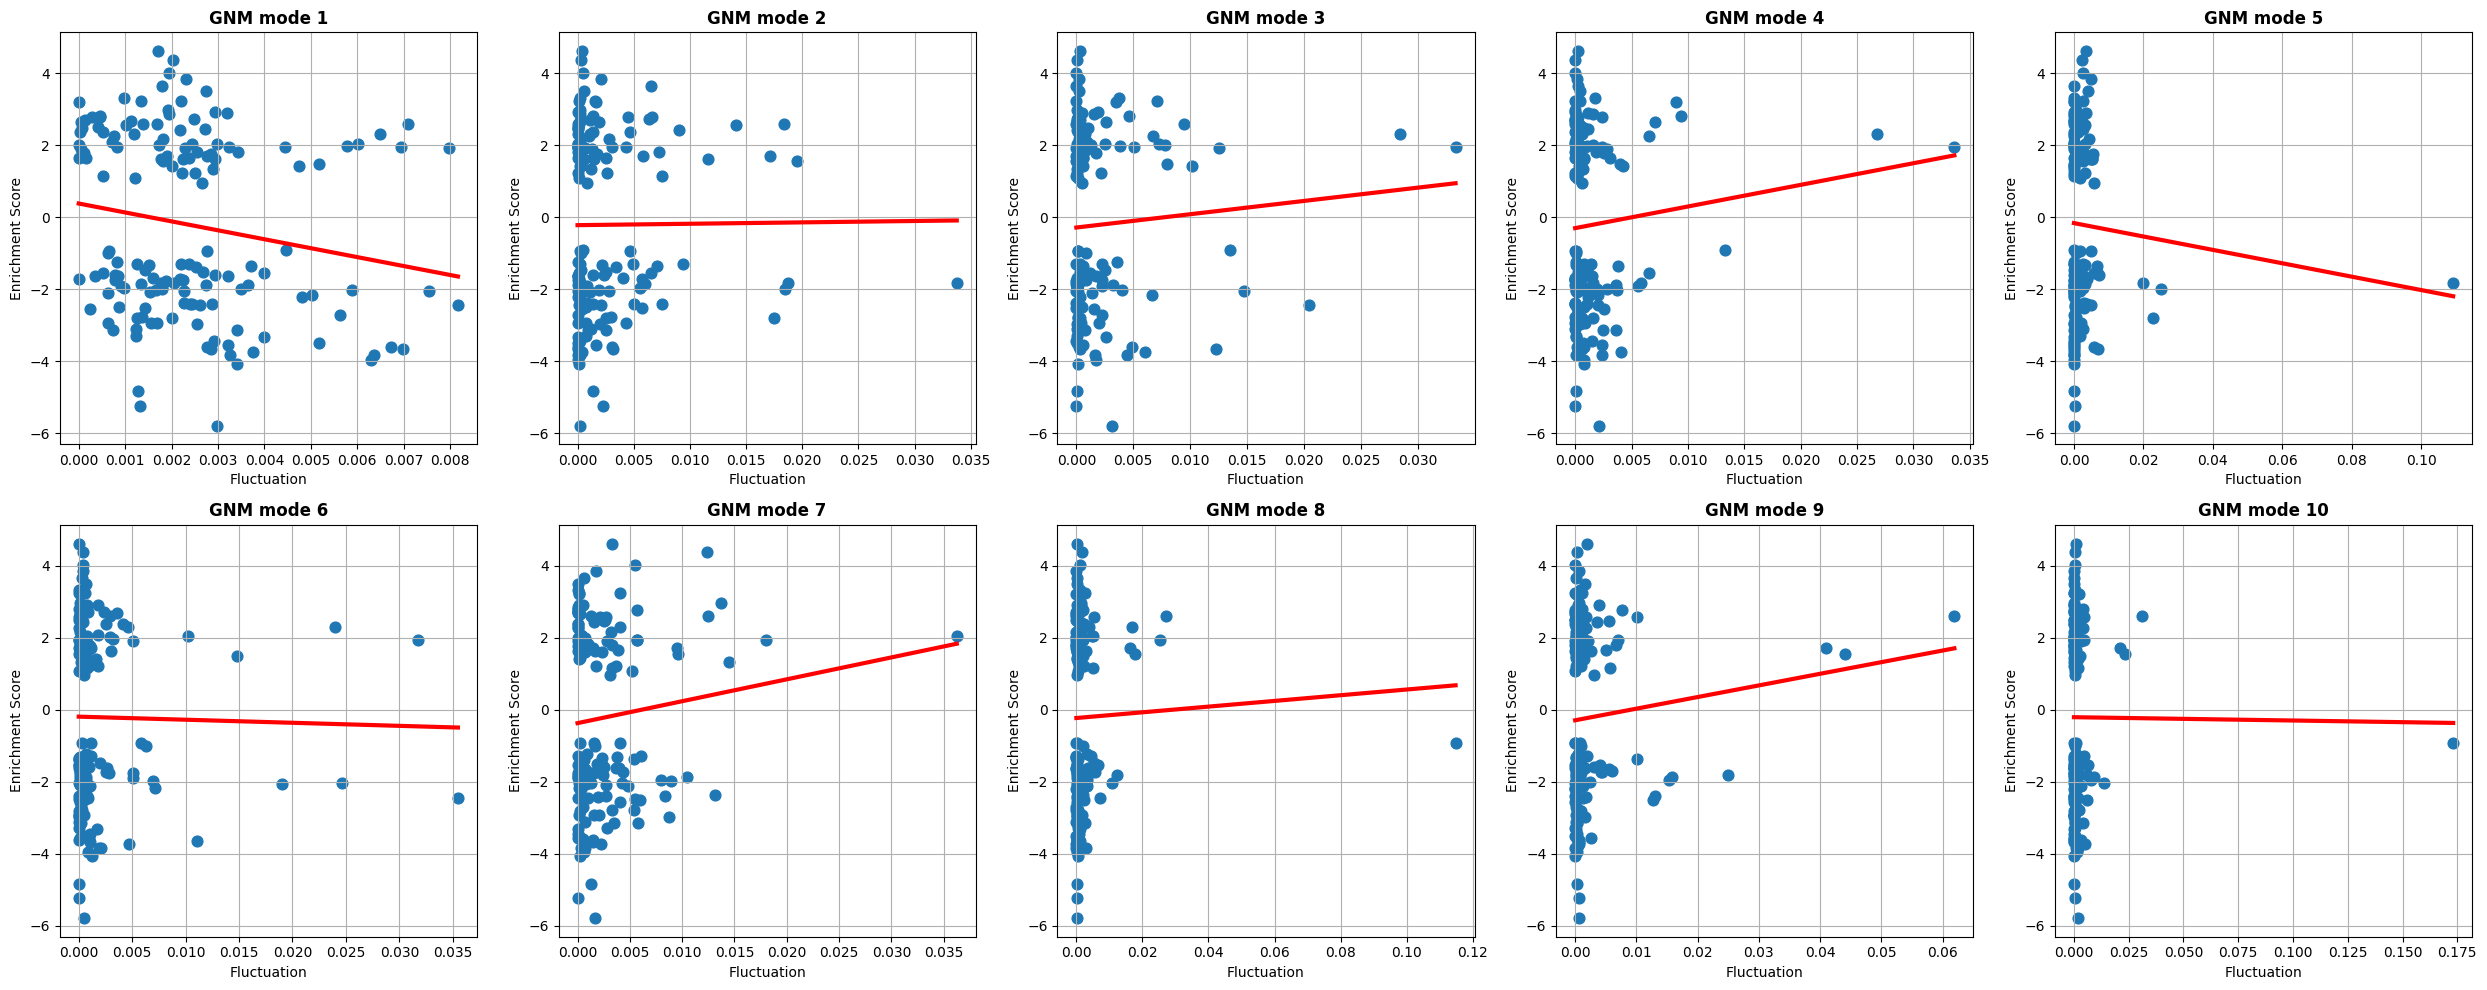

 mode_no      slopes
       1 -247.841385
       5  -18.580921
       6   -8.501849
      10   -0.920148
       2    3.853023
       8    7.908011
       9   32.268346
       3   36.890167
       4   60.041799
       7   60.806185


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import pandas as pd
import sys
from scipy.stats import linregress

# Add utils path
drive.mount('/content/drive')

sys.path.append('/content/drive/MyDrive/portfolio')
##from utils2 import GNM
from utilsclass import GNM

## Load Enrichment Data
# Ask user where to load the file from
choice = input("Do you want to upload the file from your computer (c) or Google Drive (g)? [c/g]: ").strip().lower()

if choice == "g":
    # Load from a fixed file path in Drive
    filename = "/content/drive/MyDrive/enrichment_example.csv"

elif choice == "c":
    from google.colab import files
    uploaded = files.upload()

    # Use the uploaded file name
    filename = next(iter(uploaded))

else:
    raise ValueError("Invalid choice. Please enter 'c' for computer or 'g' for Google Drive.")

# Load the file
df = pd.read_csv(filename, sep=",")

print("Enrichment scores loaded.")

## Calculate MSF Data
PDBname = "1EU8"
chainID = 'A'
mode_set = list(range(1, 11))
rcut_gnm = 10.0

# Create subplots for each mode
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))
axes = axes.flatten()  # Flatten the axes array to easily iterate
slopes=[]
count=0
for i, ax in zip(mode_set, axes):
    mode_no = [i]
    # Call the GNM function to obtain MSF for the current mode.
    GNMcall = GNM(PDBname, mode_no, chainID,rcut_gnm)
    GNMcall.eigens()
    count=count+1
    if count==1:
      print(PDBname," structure is found.")
    MSF = GNMcall.msf()
    print(f"MSF data for mode {i} is calculated.")

    # Ensure that both dataframes have a common column to merge on, such as 'Residue_Number'
    if 'ResidueNo' in MSF.columns and 'ResidueNo' in df.columns:
        # Merge MSF with df based on 'Residue_Number'
        MSF = MSF.astype(float)
        df = df.astype(float)
        merged_mode = pd.merge(df, MSF, on='ResidueNo', how='left')
        merged_mode = merged_mode.dropna()
        merged_mode = merged_mode[merged_mode['Enrichment'] != 0]        # Scatter plot
        ax.scatter(merged_mode['MSF'], merged_mode['Enrichment'], s=60)

        # Linear regression
        slope, intercept, r_value, p_value, std_err = linregress(merged_mode['MSF'], merged_mode['Enrichment'])
        slopes.append(float(slope))
        x_vals = np.array([min(merged_mode['MSF']), max(merged_mode['MSF'])])
        y_vals = intercept + slope * x_vals
        ax.plot(x_vals, y_vals, color='red', linewidth=3)

        # Labels and title
        ax.set_title(f"GNM mode {i}", fontweight='bold')
        ax.set_xlabel("GNM MSF")
        ax.set_ylabel("Enrichment Score")
        ax.grid(True)

    else:
        print(f"ResidueNo column not found in MSF or Enrichment data for mode {i}")

plt.tight_layout()
plt.show()

df_slopes = pd.DataFrame({
    'mode_no': mode_set,
    'slopes': slopes
})

# Sort the DataFrame
df_slopes_sorted = df_slopes.sort_values(by='slopes', ascending=True)

# Print without indices
print(df_slopes_sorted.to_string(index=False))
